**Importing Libraries**

In [2]:
#Import all the required libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D,Activation,Dropout,GaussianNoise
from keras.callbacks import EarlyStopping
import keras


Using TensorFlow backend.


In [3]:
#Loading the image folders and reading them
ImageFolders=[]

ImageFolders = os.listdir("C:/Users/nagar/Desktop/DSP Projects/Pool Balls")
ImageFolders

['Black_Solid_8',
 'Blue_Solid_2',
 'Blue_Stripe_12',
 'Brown_Solid_7',
 'Brown_Stripe_15',
 'Green_Solid_6',
 'Green_Stripe_14',
 'Orange_Solid_5',
 'Orange_Stripe_13',
 'Purple_Solid_4',
 'Red_Solid_3',
 'Red_Stripe_11',
 'White_Cue',
 'Yellow_Solid_1',
 'Yellow_Stripe_9']

In [4]:
#listing the images in the folders listed above
Total_data = []

from PIL import Image
ImageFile = [0] * len(ImageFolders)
length = 0
for i in range(0,len(ImageFolders)):
    ImageFile[i] = os.listdir("C:/Users/nagar/Desktop/DSP Projects/Pool Balls" + "/" + str(ImageFolders[i]))
    length = length + len(ImageFile[i])
    


In [5]:
#Converting the images into arrays and resizing them to 120*160 and storing them in a list
ImageFiles = []

for j in range(0, len(ImageFolders)):
    for k in range(0,len(ImageFile[j])):
        Img=np.array(Image.open("C:/Users/nagar/Desktop/DSP Projects/Pool Balls" + "/" + str(ImageFolders[j])+ "/" + str(ImageFile[j][k])).resize((160,120)))
        Total_data.append([Img, ImageFolders[j]])

In [6]:
#checking if the images are loaded
Total_data[0][0][0]

array([[161, 108,  56],
       [160, 105,  49],
       [161, 106,  49],
       [161, 106,  49],
       [163, 108,  54],
       [163, 115,  67],
       [167, 119,  73],
       [164, 116,  70],
       [168, 117,  70],
       [161, 107,  63],
       [154,  95,  51],
       [154,  93,  49],
       [155,  93,  52],
       [162, 106,  57],
       [169, 119,  68],
       [169, 127,  79],
       [173, 135,  96],
       [176, 138,  99],
       [172, 137,  99],
       [173, 137, 105],
       [182, 144, 108],
       [181, 143, 107],
       [179, 140,  99],
       [175, 133,  91],
       [181, 139,  97],
       [168, 124,  87],
       [158, 114,  77],
       [166, 130, 104],
       [169, 138, 120],
       [174, 141, 122],
       [153, 121, 100],
       [153, 117,  93],
       [164, 125,  96],
       [168, 124,  89],
       [179, 135,  98],
       [181, 137, 100],
       [178, 133, 100],
       [177, 132, 103],
       [167, 118,  88],
       [181, 136, 103],
       [184, 140, 105],
       [180, 135

In [7]:
#Converting the list into dataframe for preprocessing and labelling
ImageDF = pd.DataFrame(Total_data)

In [8]:
#current labels specify as color,type and number on the ball
ImageDF.head(2)

,0,1
0,"[[[161, 108, 56], [160, 105, 49], [161, 106, 4...",Black_Solid_8
1,"[[[151, 99, 49], [158, 109, 53], [162, 113, 57...",Black_Solid_8


**Pre-processing**

In [9]:
ImageDF=ImageDF.rename(columns={0: 'Images',1:'Labels'})

In [10]:
#Checking the shape of the dataframe and keeping a copy if needs a re-run
ImageDF1=ImageDF.copy()
ImageDF1.shape

(2275, 2)

We have around 2300 images in our dataset

In [11]:
#Labels to classify for this model
ImageDF1['Labels'].unique()

array(['Black_Solid_8', 'Blue_Solid_2', 'Blue_Stripe_12', 'Brown_Solid_7',
       'Brown_Stripe_15', 'Green_Solid_6', 'Green_Stripe_14',
       'Orange_Solid_5', 'Orange_Stripe_13', 'Purple_Solid_4',
       'Red_Solid_3', 'Red_Stripe_11', 'White_Cue', 'Yellow_Solid_1',
       'Yellow_Stripe_9'], dtype=object)

In [12]:
#Imagedf.value_counts
ImageDF1[['Color','Type','Number']] = ImageDF1.Labels.str.split("_",expand=True)
ImageDF1.head(3)

,Images,Labels,Color,Type,Number
0,"[[[161, 108, 56], [160, 105, 49], [161, 106, 4...",Black_Solid_8,Black,Solid,8
1,"[[[151, 99, 49], [158, 109, 53], [162, 113, 57...",Black_Solid_8,Black,Solid,8
2,"[[[167, 118, 42], [165, 117, 51], [161, 114, 4...",Black_Solid_8,Black,Solid,8


In [13]:
#Considering only the color and type of the ball
ImageDF_Color = ImageDF1[['Images','Color','Type']]
ImageDF_Color.head(3)

,Images,Color,Type
0,"[[[161, 108, 56], [160, 105, 49], [161, 106, 4...",Black,Solid
1,"[[[151, 99, 49], [158, 109, 53], [162, 113, 57...",Black,Solid
2,"[[[167, 118, 42], [165, 117, 51], [161, 114, 4...",Black,Solid


In [14]:
ImageDF_Color['ColorType']=ImageDF_Color['Color']+ImageDF_Color['Type']

C:\Users\nagar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#--------------------------------------------------------------------------------------#

#Second Level Classification --> Identifying the pool ball with color and type

In [15]:
ImageDF_Final = ImageDF_Color.drop(columns=['Color','Type'])

In [16]:
#Final dataframe for modelling
ImageDF_Final.head(2)

,Images,ColorType
0,"[[[161, 108, 56], [160, 105, 49], [161, 106, 4...",BlackSolid
1,"[[[151, 99, 49], [158, 109, 53], [162, 113, 57...",BlackSolid


In [17]:
#splitting train and test with equal distribution
split = StratifiedShuffleSplit(n_splits=5,test_size = 0.2,random_state = 42)
print(split)
for train_index,test_index in split.split(ImageDF_Final,ImageDF_Final["ColorType"]):
    train_set = ImageDF_Final.iloc[train_index]
    test_set = ImageDF_Final.iloc[test_index]

#Checking how the split is
print(ImageDF_Final["ColorType"].value_counts()/len(ImageDF_Final))
print("----------------------------------------------------")
print(train_set["ColorType"].value_counts()/len(train_set))
print("----------------------------------------------------")
print(test_set["ColorType"].value_counts()/len(test_set))


StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None)
RedSolid        0.134505
GreenStripe     0.095824
WhiteCue        0.083956
GreenSolid      0.079121
BrownStripe     0.070769
BrownSolid      0.065495
YellowSolid     0.064176
BlackSolid      0.060220
RedStripe       0.058022
YellowStripe    0.051868
BlueSolid       0.050110
OrangeSolid     0.048352
BlueStripe      0.047912
OrangeStripe    0.045714
PurpleSolid     0.043956
Name: ColorType, dtype: float64
----------------------------------------------------
RedSolid        0.134615
GreenStripe     0.095604
WhiteCue        0.084066
GreenSolid      0.079121
BrownStripe     0.070879
BrownSolid      0.065385
YellowSolid     0.064286
BlackSolid      0.060440
RedStripe       0.058242
YellowStripe    0.051648
BlueSolid       0.050000
OrangeSolid     0.048352
BlueStripe      0.047802
OrangeStripe    0.045604
PurpleSolid     0.043956
Name: ColorType, dtype: float64
-------------------------------------

In [18]:
#Validation set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_set["Images"],train_set["ColorType"],test_size=0.2,random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1456,) (364,) (1456,) (364,)


In [19]:
#Transforming the labels to factor variables
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_train_encoded= encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

In [20]:
y_train_new_array = np.array(y_train_encoded)
y_test_new_array=np.array(y_test_encoded)

In [21]:
#Convert class vectors to binary class matrices.
y_train_cat = keras.utils.to_categorical(y_train_new_array, num_classes=15)
y_test_cat = keras.utils.to_categorical(y_test_new_array, num_classes=15)

In [22]:
#checking the shapes of y train and y test
print(y_train_cat.shape,y_test_cat.shape)

(1456, 15) (364, 15)


Converting the y variables to arrays for modelling

In [23]:
y_train_new_array=np.array(y_train_cat)

In [24]:
y_test_new_array=np.array(y_test_cat)

Converting 3d shapes to 4D tensors for keras model

In [25]:
#converting each 3d image in a list into 4D tensor array as we need for input to CNN
X_train_new =[0] * len(X_train) 
for i in range(0,len(X_train)):
    X_train_new[i] = np.reshape((X_train.iloc[i]),(120,160,3))

X_train_array = np.asarray(X_train_new)

X_test_new=[0] * len(X_test)
for i in range(0,len(X_test)):
    X_test_new[i] = np.reshape((X_test.iloc[i]),(120,160,3))
X_test_array = np.asarray(X_test_new)

X_train_array = X_train_array.astype('float32')
X_test_array = X_test_array.astype('float32')
X_train_array /= 255
X_test_array /= 255

In [26]:
X_train_array.shape

(1456, 120, 160, 3)

Why we can't use Fully connected Neural network?
more number of weights which would eventually overfit model
Cnn's take the nearest values to explore structure in the image i.e, less number of weights  

**Modelling**

In [31]:
#Architecture for the CNN

model = Sequential()
#1st layer
model.add(Conv2D(32, (3, 3), padding='same',input_shape=X_train_array.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(GaussianNoise(0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
#3rd dense layer
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(GaussianNoise(0.1))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
#5th dense layer
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(GaussianNoise(0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Flattening
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(15))
model.add(Activation('softmax'))

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 120, 160, 32)      896       
_________________________________________________________________
activation_9 (Activation)    (None, 120, 160, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 118, 158, 32)      9248      
_________________________________________________________________
activation_10 (Activation)   (None, 118, 158, 32)      0         
_________________________________________________________________
gaussian_noise_6 (GaussianNo (None, 118, 158, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 59, 79, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 59, 79, 32)       

In [33]:
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',optimizer="sgd",metrics=['accuracy'])


In [34]:
# #fitting model
history= model.fit(X_train_array, y_train_new_array,batch_size=32,epochs=15,validation_data=(X_test_array, y_test_new_array),shuffle=True)

Train on 1456 samples, validate on 364 samples
Epoch 1/15
1456/1456 [==============================] - 192s 132ms/step - loss: 2.6995 - accuracy: 0.1058 - val_loss: 2.6986 - val_accuracy: 0.1484
Epoch 2/15
1456/1456 [==============================] - 201s 138ms/step - loss: 2.6673 - accuracy: 0.1387 - val_loss: 2.6968 - val_accuracy: 0.1841
Epoch 3/15
1456/1456 [==============================] - 192s 132ms/step - loss: 2.6571 - accuracy: 0.1387 - val_loss: 2.6870 - val_accuracy: 0.1978
Epoch 4/15
1456/1456 [==============================] - 191s 131ms/step - loss: 2.6413 - accuracy: 0.1415 - val_loss: 2.6615 - val_accuracy: 0.1758
Epoch 5/15
1456/1456 [==============================] - 191s 131ms/step - loss: 2.5233 - accuracy: 0.2033 - val_loss: 2.3935 - val_accuracy: 0.2692
Epoch 6/15
1456/1456 [==============================] - 206s 142ms/step - loss: 2.0740 - accuracy: 0.3393 - val_loss: 1.7505 - val_accuracy: 0.4313
Epoch 7/15
1456/1456 [==============================] - 194s 133m

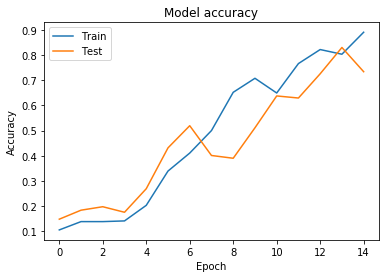

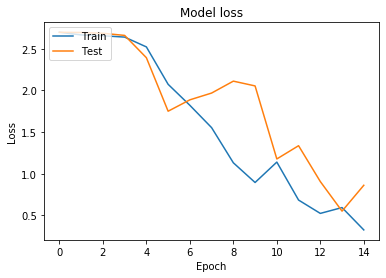

In [35]:
#Assessing the learning curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

From the above analysis, our model was performed well on the validation set with 93% accuracy and the learning curves are showing that there is very less chance of overfitting as the training and testing curves are much closer to each other.

Testing on the holdout set

In [36]:
X_test=test_set["Images"]
y_test=test_set["ColorType"]

In [37]:
#Transforming the test set as we transformed the trainset and trained on it
from sklearn.preprocessing import LabelEncoder
y_test_encoded= encoder.transform(y_test)
y_test_array=np.array(y_test_encoded)
y_test_cat = keras.utils.to_categorical(y_test_array, num_classes=15)

X_test_1=[0] * len(X_test)
for i in range(0,len(X_test)):
    X_test_1[i] = np.reshape((X_test.iloc[i]),(120,160,3))
X_test_1 = np.asarray(X_test_1)

# X_test_1 = X_test_1.astype('float32')
X_test_1 = X_test_1/255

In [38]:
#Checking the accuracy of the model on test set
scores = model.evaluate(X_test_1, y_test_cat, verbose=True)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

455/455 [==============================] - 21s 45ms/step
Test loss: 0.8758491705079655
Test accuracy: 0.8021978139877319


In [41]:
predictions = model.predict_classes(X_test_1)

In [47]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_array, predictions)

array([[23,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1, 20,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 30,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 32,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  3,  0,  0,  0, 32,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  6,  0,  0, 11,  0, 22,  0,  0,  0,  0,  1,  0,  0,  4],
       [ 0,  2,  0,  0,  0,  0,  0, 19,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0, 20,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  3,  0,  1,  0, 15,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 61,  0,  0,  0,  0],
       [ 0,  6,  0,  0,  5,  0,  2,  0,  0,  0,  0, 13,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 38,  0,  0],
       [ 0,  3,  0,  0,  5,  2,  5,  0,  6,  0,  0,  3,  0,  4,  1],
       [ 0,  2,  2,  0,  6,  1,  0

In [52]:
#f1 score
from sklearn.metrics import f1_score
print('Precision score of 1st level classifier:%.2f'%f1_score(y_test_array, predictions,average="micro"))

Precision score of 1st level classifier:0.80


An attempt to generalize the model by using Keras ImageDataGenerator

In [53]:
from keras.preprocessing.image import ImageDataGenerator

In [54]:
#Setting the best possible values in our runs by tweaking and keeping the best result
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False, 
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.,  
        zoom_range=0., 
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)
datagen.fit(X_train_array)
history1=model.fit_generator(datagen.flow(X_train_array, y_train_new_array,batch_size=32),
                        epochs=20,
                        validation_data=(X_test_array, y_test_new_array),
                        workers=4)

Epoch 1/20
46/46 [==============================] - 189s 4s/step - loss: 2.7873 - accuracy: 0.1600 - val_loss: 2.0611 - val_accuracy: 0.4286
Epoch 2/20
46/46 [==============================] - 366s 8s/step - loss: 2.2353 - accuracy: 0.2582 - val_loss: 1.8151 - val_accuracy: 0.4615
Epoch 3/20
46/46 [==============================] - 223s 5s/step - loss: 1.9427 - accuracy: 0.3455 - val_loss: 1.7135 - val_accuracy: 0.4368
Epoch 4/20
46/46 [==============================] - 193s 4s/step - loss: 1.8014 - accuracy: 0.3984 - val_loss: 1.5691 - val_accuracy: 0.5055
Epoch 5/20
46/46 [==============================] - 191s 4s/step - loss: 1.7563 - accuracy: 0.4176 - val_loss: 1.5325 - val_accuracy: 0.4973
Epoch 6/20
46/46 [==============================] - 191s 4s/step - loss: 1.6189 - accuracy: 0.4430 - val_loss: 1.5753 - val_accuracy: 0.5137
Epoch 7/20
46/46 [==============================] - 193s 4s/step - loss: 1.4679 - accuracy: 0.5055 - val_loss: 1.5264 - val_accuracy: 0.4643
Epoch 8/20
46

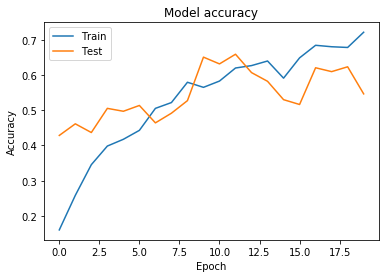

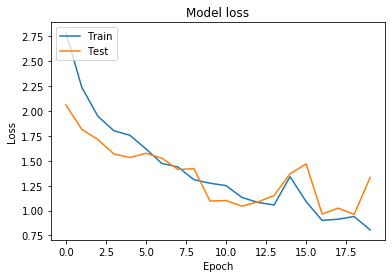

In [55]:
#Assessing the model
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [56]:
X_test=test_set["Images"]
y_test=test_set["ColorType"]

In [60]:
#Transforming the test set as we transformed the trainset and trained on it
from sklearn.preprocessing import LabelEncoder
y_test_encoded= encoder.transform(y_test)
y_test_array=np.array(y_test_encoded)
y_test_cat = keras.utils.to_categorical(y_test_array, num_classes=15)

X_test_1=[0] * len(X_test)
for i in range(0,len(X_test)):
    X_test_1[i] = np.reshape((X_test.iloc[i]),(120,160,3))
X_test_1 = np.asarray(X_test_1)

# X_test_1 = X_test_1.astype('float32')
X_test_1 = X_test_1/255

In [61]:
#Evaluating model
scores = model.evaluate(X_test_1, y_test_cat, verbose=True)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

455/455 [==============================] - 19s 42ms/step
Test loss: 1.3337275080628448
Test accuracy: 0.5736263990402222


In [62]:
predictions = model.predict_classes(X_test_1)

Evaluation part: Confusion matrix and F1 Score

In [63]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_array, predictions)

array([[10, 15,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 11, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 4,  2,  0, 24,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 29,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  6,  1,  0,  0, 29,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 22,  3,  0,  6, 12,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 3,  0,  0,  0,  4,  0,  0, 13,  0,  0,  0,  2,  0,  0,  0],
       [ 0,  1,  0,  0,  3,  0,  3,  0, 14,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0, 13,  0,  0,  0,  6,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 61,  0,  0,  0,  0],
       [ 0,  7,  0,  0,  9,  1,  6,  0,  0,  0,  0,  3,  0,  0,  0],
       [ 0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0, 36,  0,  0],
       [ 1,  5,  1,  0,  7,  0,  5,  0,  7,  0,  2,  1,  0,  0,  0],
       [ 0,  2,  3,  0, 11,  3,  4

In [64]:
#f1 score
from sklearn.metrics import f1_score
print('Precision score of 1st level classifier:%.2f'%f1_score(y_test_array, predictions,average="micro"))

Precision score of 1st level classifier:0.57
